In [2]:
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
import numpy as np
from scipy import stats
import shap

<h1 style="text-align:center">Response Prediction Using XGBoost Classifier</h1>

Source Codes:
- [XGBoost Hyperparameter Tuning (Optuna)](https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py)
- [XGBoost Binary Classification Pipeline](https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn#Binary-classification)

In [41]:
data = pd.read_csv("../../data/phq9_data.csv")
data.phq9_response = data.phq9_response.map({1:1, 2:0})
target = data.phq9_response
neg, pos = target.value_counts()

In [42]:
SEED = 42
N_FOLDS = 10
SPW = neg / pos

In [43]:
def objective(trial):
    data = pd.read_csv("../../data/phq9_data.csv")
    data.phq9_response = data.phq9_response.map({1:1, 2:0})
    y = data.pop("phq9_response")
    X = data

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "use_label_encoder": False,
        "eval_metric": "auc",
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        )

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical(
            "sample_type", ["uniform", "weighted"]
        )
        param["normalize_type"] = trial.suggest_categorical(
            "normalize_type", ["tree", "forest"]
        )
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    mcc_scores = []
    best_n_estimators_list = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        clf = xgb.XGBClassifier(
            **param,
            n_estimators=10000,
            early_stopping_rounds=100,
            seed=SEED,
            scale_pos_weight=SPW,
        )

        clf.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False,
        )

        preds = clf.predict(X_valid)
        mcc = matthews_corrcoef(y_valid, preds)
        mcc_scores.append(mcc)
        best_n_estimators_list.append(clf.best_iteration)

    trial.set_user_attr("n_estimators", int(np.mean(best_n_estimators_list)))
    return np.mean(mcc_scores)


if __name__ == "__main__":
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=200, timeout=1800)
    best_trial = study.best_trial

    print(f"Max MCC Value: {best_trial.value}")

    best_params = study.best_params
    n_estimators = best_trial.user_attrs["n_estimators"]

[I 2025-09-16 17:36:52,417] A new study created in memory with name: no-name-eaf161f2-58a0-4a4b-b69a-555a43a6dfab
[I 2025-09-16 17:36:55,244] Trial 0 finished with value: 0.0 and parameters: {'booster': 'dart', 'lambda': 0.47352627995770036, 'alpha': 0.046637077396965224, 'subsample': 0.9283067036152031, 'colsample_bytree': 0.3901540864686586, 'max_depth': 7, 'min_child_weight': 3, 'eta': 3.370734951007106e-08, 'gamma': 0.007658515564263013, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.2324460912827586e-07, 'skip_drop': 1.3405222173736285e-07}. Best is trial 0 with value: 0.0.
[I 2025-09-16 17:36:55,914] Trial 1 finished with value: -0.03162277660168379 and parameters: {'booster': 'gblinear', 'lambda': 0.4127591092319869, 'alpha': 0.00973135706611041, 'subsample': 0.7964500923079656, 'colsample_bytree': 0.7892585585689993}. Best is trial 0 with value: 0.0.
[I 2025-09-16 17:36:56,711] Trial 2 finished with value: 0.0 and parameters: {'b

Max MCC Value: 0.12899703909680416


In [44]:
def metric_ci(scores):
    mean = np.mean(scores)
    sem = stats.sem(scores)
    ci = stats.t.interval(0.95, len(scores)-1, loc=mean, scale=sem)
    return f"Mean: {mean:.3f} (95% CI: {ci[0]:.3f}-{ci[1]:.3f})"

def eval_best_model():
    data = pd.read_csv("../../data/phq9_data.csv")
    data.phq9_response = data.phq9_response.map({1:1, 2:0})
    y = data.pop("phq9_response")
    X = data
    
    n_folds = 10
    spw = 1.56
    seed = 42

    best_trial = study.best_trial
    n_estimator = best_trial.user_attrs["n_estimators"]

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    mccs, accs, f1s = [], [], []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = xgb.XGBClassifier(
            **best_params,
            verbosity=0,
            use_label_encoder=False,
            objective="binary:logistic",
            random_state=seed,
            scale_pos_weight=spw,
            eval_metric="auc",
            n_estimators=n_estimators,
            early_stopping_rounds=100,
        )

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=False,
        )

        preds = model.predict(X_valid)

        mccs.append(matthews_corrcoef(y_valid, preds))
        accs.append(accuracy_score(y_valid, preds))
        f1s.append(f1_score(y_valid, preds))

    print(f"Optuna MCC {best_trial.value}\n")
    print(f"MCC {metric_ci(mccs)}")
    print(f"Accuracy {metric_ci(accs)}")
    print(f"F1 Score {metric_ci(f1s)}")

In [46]:
eval_best_model()

Optuna MCC 0.12899703909680416

MCC Mean: -0.047 (95% CI: -0.198-0.103)
Accuracy Mean: 0.607 (95% CI: 0.522-0.692)
F1 Score Mean: 0.738 (95% CI: 0.664-0.812)


In [47]:
best_trial.params

{'booster': 'gblinear',
 'lambda': 7.467518518607648e-07,
 'alpha': 0.0007421777890541159,
 'subsample': 0.8783913966490335,
 'colsample_bytree': 0.250194492608836}

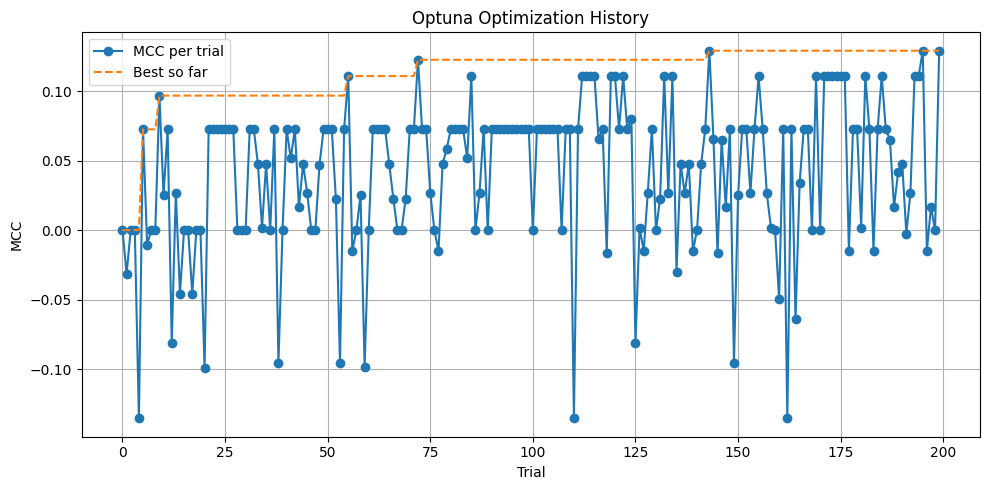

In [48]:
import matplotlib.pyplot as plt

values = [t.value for t in study.trials]

plt.figure(figsize=(10, 5))
plt.plot(values, marker="o", label="MCC per trial")
plt.plot(np.maximum.accumulate(values), label="Best so far", linestyle="--")
plt.title("Optuna Optimization History")
plt.xlabel("Trial")
plt.ylabel("MCC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SHAP

In [65]:

def model_shap():
    data = pd.read_csv("../../data/phq9_data.csv")
    data.phq9_response = data.phq9_response.map({1:1, 2:0})
    y = data.pop("phq9_response")
    X = data
    n_folds = 10
    spw = 1.56
    seed = 42

    final_model = xgb.XGBClassifier(
                **best_params,
                verbosity=0,
                use_label_encoder=False,
                objective="binary:logistic",
                random_state=seed,
                scale_pos_weight=spw,
                eval_metric="auc",
                n_estimators=n_estimators
            )

    final_model.fit(X,y)
    explainer = shap.LinearExplainer(final_model, shap.maskers.Independent(X))
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, plot_type="violin", max_display=X.shape[1])

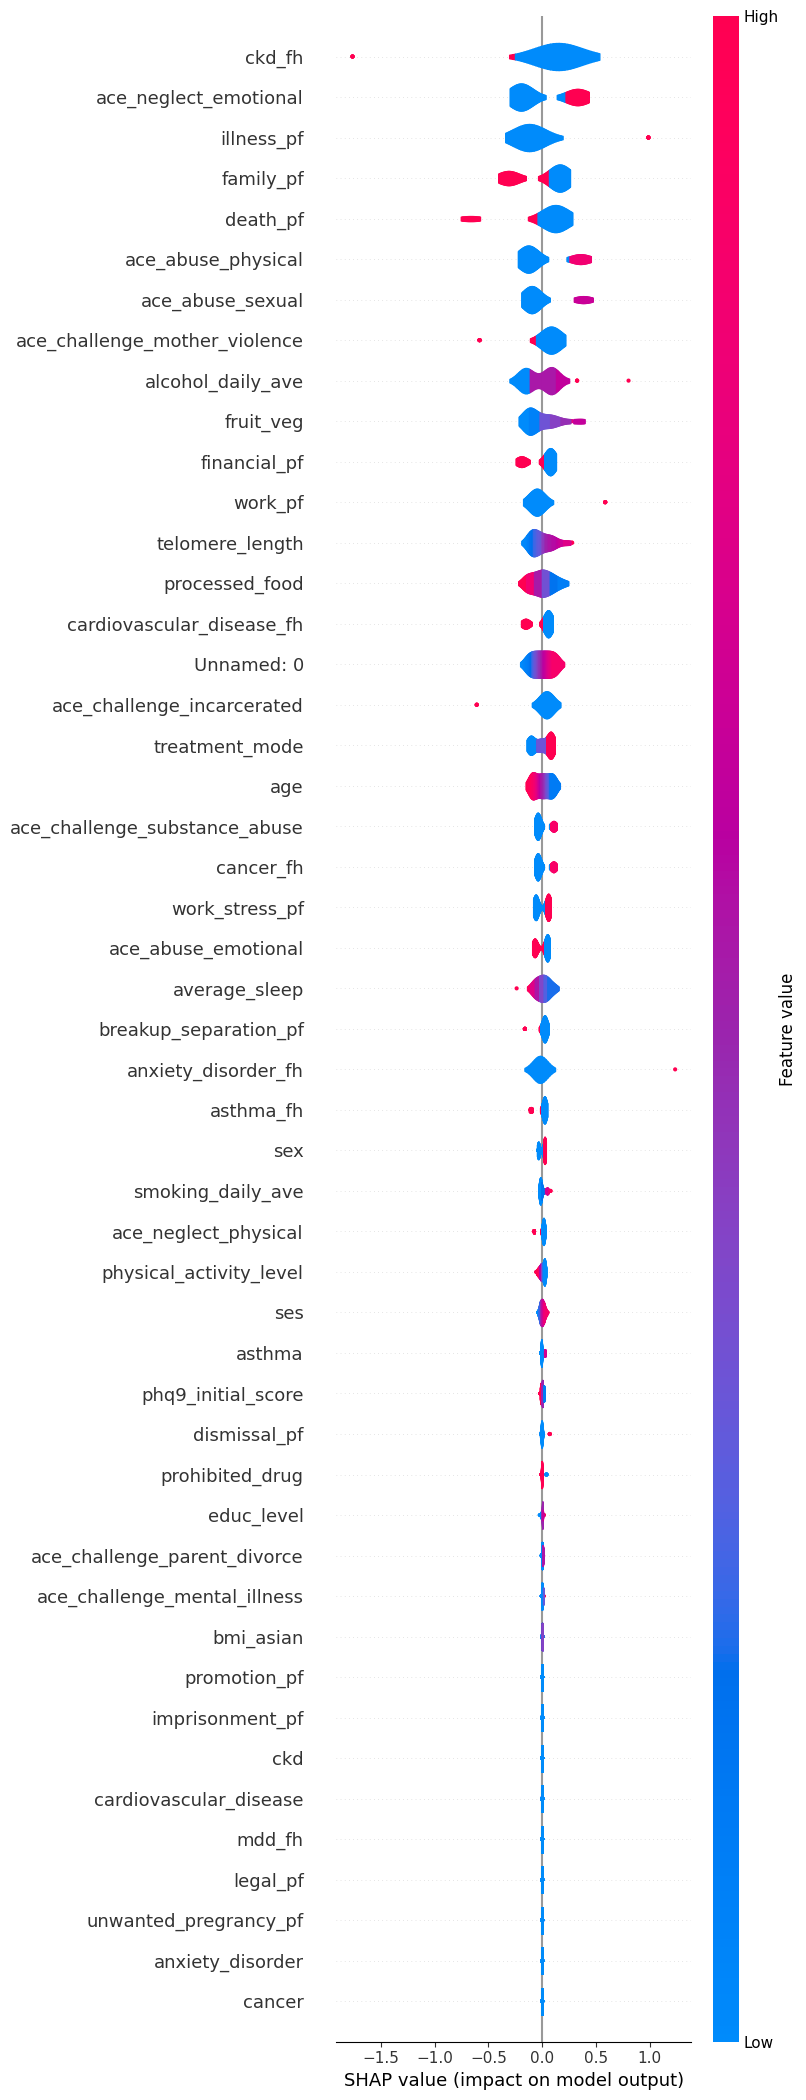

In [66]:
model_shap()